This summarises what is found in Lesson 3 of the Stats501 in Penn State University's Regression Methods Course

This lesson deals with SLR's model estimation and prediction. 

https://newonlinecourses.science.psu.edu/stat501/node/271/

**Estimate $\mu_y$**

1. $\mu_y$ is the population mean of $y$ while $\bar{y}$ is the sample mean
2. In order to infer the $\mu_y$, we can reasonably use $\bar{y}$ to do an estimate.
3. However, in this case, how confident are we? We can use an estimate interval for such a thing

**Predict $y$**

1. What would be a good estimate for predicting $y$? It seems reasonable to calculate a 'prediction interval' for using $\bar{y}$ 

There is a difference between getting the $\mu_y$ and predicting y. Why that is so is pretty abstract and takes alot of convincing to a normie like me.


However, since this is part of this whole rollercoaster, let's assume that we are answering two questions - 

1. What is the mean response $µ_Y$ when the predictor value is $x_h$?
2. What value will a new response $y_{new}$ be when the predictor value is $x_h$?

The best way to think about this is this - 

1. What is the expected (mean) mortality rate due to skin cancer for **all locations** at 40 degrees north latitude?
2. What is the predicted mortality rate for **one individual location** at 40 degrees north, say at Chambersburg, Pennsylvania?

They may look the same ($\hat{y}_h=b_0+b_1x_h$) but this may change if we receive a new set of data.

We'll be looking again at the skincancer data set

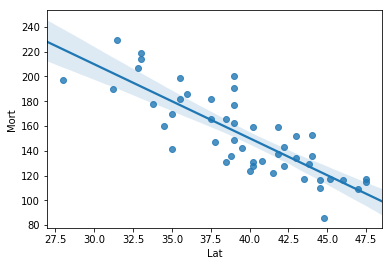

In [30]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import t

data = pd.read_csv('skincancer.csv')

sns.regplot(data.Lat, data.Mort)
plt.show()

In [31]:
X = sm.add_constant(data.Lat)
result = sm.OLS(data.Mort, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Mort   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     99.80
Date:                Thu, 27 Jun 2019   Prob (F-statistic):           3.31e-13
Time:                        09:34:25   Log-Likelihood:                -213.08
No. Observations:                  49   AIC:                             430.2
Df Residuals:                      47   BIC:                             433.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        389.1894     23.812     16.344      0.000     341.285     437.094
Lat           -5.9776      0.598     -9.990      0.000      -7.181      -4.774
==============================================================================
Omnibus:                        0.740   Durbin-Watson:                   2.131
Prob(Omnibus):                  0.691   Jarque-Bera (JB):                0.773
Skew:                           0.094   Prob(JB):                        0.679
Kurtosis:                       2.414   Cond. No.                         347.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Confidence Interval of Mean Response

**$µ_Y$ when the predictor value is $x_h$ (Expected mean response given a predictor value)**

Sample estimate ± (t-multiplier × standard error)

$\hat{y}_h \pm t_{(\alpha/2, n-2)} \times \sqrt{MSE \times \left( \frac{1}{n} + \frac{(x_h-\bar{x})^2}{\sum(x_i-\bar{x})^2}\right)}$

Where:
- $\hat{y}_h$ is the predicted value
- $t_{(\alpha/2, n-2)}$ is the t-multiplier
- $\sqrt{MSE \times \left( \frac{1}{n} + \frac{(x_h-\bar{x})^2}{\sum(x_i-\bar{x})^2}\right)}$ is the standard error fit

Without statsmodels (besides what we have done before), we can create function to get this interval:

In [32]:
def CIMeanY(result, predvalue, X, x):
    yhat = result.predict(pd.DataFrame({'const': [1.0], 'Lat': [predvalue]}))
    mse = result.mse_resid #look at L1 for how to get mse in the first place
    stderror = (mse * (1/len(X) + ((predvalue - x.mean()) ** 2 / sum((x - x.mean())**2))))**0.5
    tmult = t.ppf(0.975, df = (len(X) - 2))
    lower = yhat - (tmult * stderror)
    upper = yhat + (tmult*stderror)
    return lower.iloc[0], upper.iloc[0]

print (CIMeanY(result, 40, X, data.Lat))

(144.56169307209458, 155.60614943618933)


## Prediction Interval

$\hat{y}_h \pm t_{(\alpha/2, n-2)} \times \sqrt{MSE \left( 1+\frac{1}{n} + \frac{(x_h-\bar{x})^2}{\sum(x_i-\bar{x})^2}\right)}$

Sample estimate ± (t-multiplier × standard error)

Where:
- $\hat{y}_h$ is the predicted value
- $t_{(\alpha/2, n-2)}$ is the t-multiplier
- $\sqrt{MSE \left( 1+\frac{1}{n} + \frac{(x_h-\bar{x})^2}{\sum(x_i-\bar{x})^2}\right)}$ is the standard error of the prediction, which is very similar to the standard error of the fit when estimating $µ_Y$. The standard error of the prediction just has an extra MSE term added that the standard error of the fit does not.

Again, we can create a function similar to the CIMeanY to get the prediction interval

In [33]:
def PIofYhat(result, predvalue, X, x):
    yhat = result.predict(pd.DataFrame({'const': [1.0], 'Lat': [predvalue]}))
    mse = result.mse_resid #look at L1 for how to get mse in the first place
    stderror = (mse * (1 + (1/len(X)) + ((predvalue - x.mean()) ** 2 / sum((x - x.mean())**2))))**0.5
    tmult = t.ppf(0.975, df = (len(X) - 2))
    lower = yhat - (tmult * stderror)
    upper = yhat + (tmult*stderror)
    return lower.iloc[0], upper.iloc[0]

print (PIofYhat(result, 40, X, data.Lat))

(111.234957047654, 188.9328854606299)


**Using statsmodels to get the CI and PI**

In [34]:
predvalues = pd.DataFrame({'const': [1.0], 'Lat': [40.0]})

sumframe = result.get_prediction(predvalues).summary_frame(alpha=0.05)
# when40 = data[data.Lat==40].index[0]
# print("CI: ", sumframe.iloc[when40].loc['mean_ci_lower'], ",", sumframe.iloc[when40].loc['mean_ci_upper'])
# print ("PI: ", sumframe.iloc[when40].loc['obs_ci_lower'], ",", sumframe.iloc[when40].loc['obs_ci_upper'])
# sumframe.iloc[when40]
sumframe

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,150.083921,2.745,144.561693,155.606149,111.234957,188.932885


**Alternate Method with Statsmodels**

In [35]:
from statsmodels.stats.outliers_influence import summary_table

print(summary_table(result, alpha=0.05)[1][11])
print(summary_table(result, alpha=0.05)[2])

[ 1.20000000e+01  1.24000000e+02  1.50083921e+02  2.74500024e+00
  1.44561693e+02  1.55606149e+02  1.11234957e+02  1.88932885e+02
 -2.60839213e+01  1.89169061e+01 -1.37886825e+00  2.00170513e-02]
['Obs', 'Dep Var\nPopulation', 'Predicted\nValue', 'Std Error\nMean Predict', 'Mean ci\n95% low', 'Mean ci\n95% upp', 'Predict ci\n95% low', 'Predict ci\n95% upp', 'Residual', 'Std Error\nResidual', 'Student\nResidual', "Cook's\nD"]


Not my favourite method because messy to figure out.

## Findings

With a CI of (144.56, 155.61), we can say that 95% of Mean Y ($\mu_y$) values will fall within this range when $x_h$ is at 40. 

With a PI of (111.23, 188.93), we can say that 95% of predicted values of Y will within this range when we give an input of $x_h$ = 40.

**When to use the formula**

- When $x_h$ is a value within the range of the x values in the data set — that is, when $x_h$ is a value within the "scope of the model." But, note that $x_h$ does not have to be one of the actual x values in the data set.
- When the "LINE" conditions — linearity, independent errors, normal errors, equal error variances — are met. The formula works okay even if the error terms are only approximately normal. And, if you have a large sample, the error terms can even deviate substantially from normality.